In [1]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import copy
import math


from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import seaborn as sns
import matplotlib.dates as mdates



import warnings
warnings.filterwarnings("ignore") # In order not to show the warnings in the notebook


# Introduction
Time series forecasting has been dominated by linear
methods because they are well understood and effective on
many simpler forecasting problems. However, by using
deep learning we are able to automatically learn arbitrary
complex mappings from inputs to outputs. The bitcoin
price prediction that has been worked on in this project is a
regression problem, where the prediction model predicts the
next Bitcoin price based on the previous. We studied, implemented and compared various Machine Learning and deep
learning methods, such as, prophet, Convolutional Neural
Network (CNN) and long short-term memory (LSTM).

## Data Used

The dataset in the project is imported by Python using
Yahoo APIs and contains the USD bitcoin price of each day
from 2014 to 2021 and it includes six features: Open indicates the price at the beginning of the day, Close indicates
the price at the end of the day, Adjusted Close, Volume of
the sale, High price of the day and Low price of the day.

## 1. Data Preprocessing

### a. Importing and Analysing the Data

In [2]:
# Importing data 
Bitcoin_data = pd.read_csv('data.csv', parse_dates=['Date'], sep=',', index_col='Date')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
Bitcoin_data.head(5)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,457.334015
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002
2014-09-18,424.102997,427.834992,384.532013,394.795990,37919700.0,394.795990
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992
2014-09-20,408.084992,412.425995,393.181000,398.821014,26580100.0,398.821014


In [3]:
# checking for nulls
Bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2014-09-16 to 2021-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2586 non-null   float64
 1   High       2586 non-null   float64
 2   Low        2586 non-null   float64
 3   Adj Close  2586 non-null   float64
 4   Volume     2586 non-null   float64
 5   Close      2586 non-null   float64
dtypes: float64(6)
memory usage: 141.4 KB


The
dataset has been examined for null values and it didn’t have any missing values.

In [4]:
# checking if close is not equal to adj close
Bitcoin_data[Bitcoin_data['Close']!=Bitcoin_data['Adj Close']]

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,


The ‘Close’ and ‘Adj Close’
columns are identical because Cryptocurrency prices differ
from traditional stock prices. So ‘Close’ price is chosen as
the target variable.

In [5]:
# checking the main parameters
Bitcoin_data.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2586.000000,2586.000000,2586.000000,2586.000000,2.586000e+03,2586.000000
mean,9460.479761,9729.703537,9173.223236,9483.798763,1.375499e+10,9483.798763
std,13881.464139,14299.916556,13424.115329,13919.027751,1.989196e+10,13919.027751
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,577.754990,582.823242,573.438751,577.567490,7.406615e+07,577.567490
50%,5515.076172,5647.827149,5353.012940,5540.485108,4.568140e+09,5540.485108
75%,9699.704834,9908.871582,9507.834717,9700.673340,2.224211e+10,9700.673340
max,63523.753910,64863.097660,62208.964840,63503.457030,3.510000e+11,63503.457030


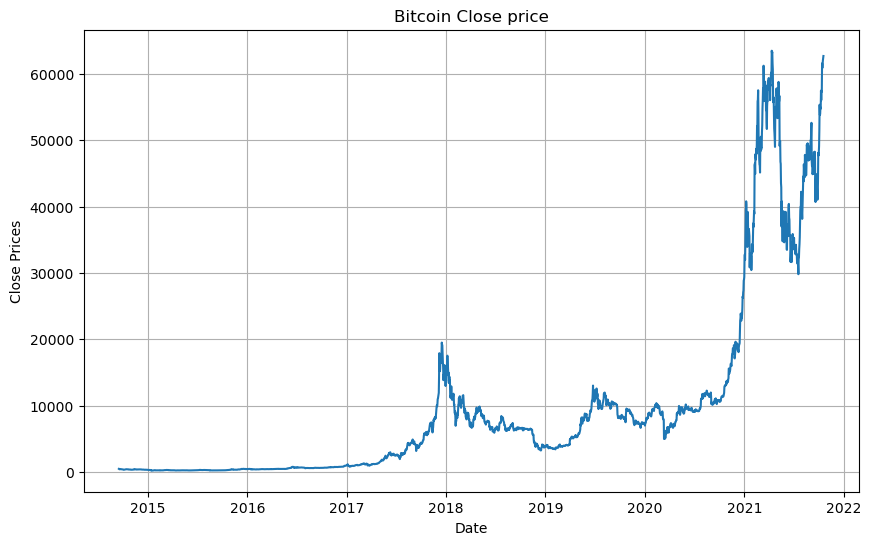

In [6]:
# Plot closing prices
df_close = Bitcoin_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Bitcoin Close price');

### b. Checking Stationarity

In [7]:
  def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

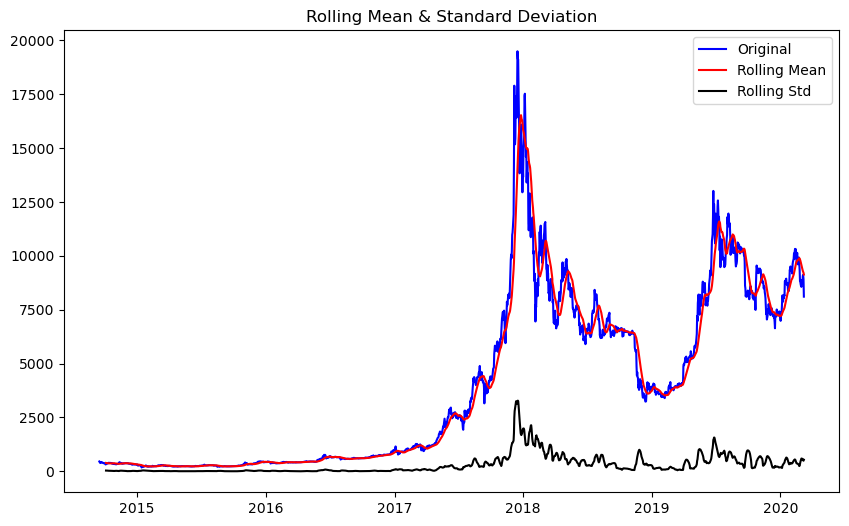

Results of Dickey-Fuller Test:
Test Statistic                   -1.744147
p-value                           0.408522
#Lags Used                       21.000000
Number of Observations Used    1978.000000
Critical Value (1%)              -3.433660
Critical Value (5%)              -2.863002
Critical Value (10%)             -2.567548
dtype: float64


In [8]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

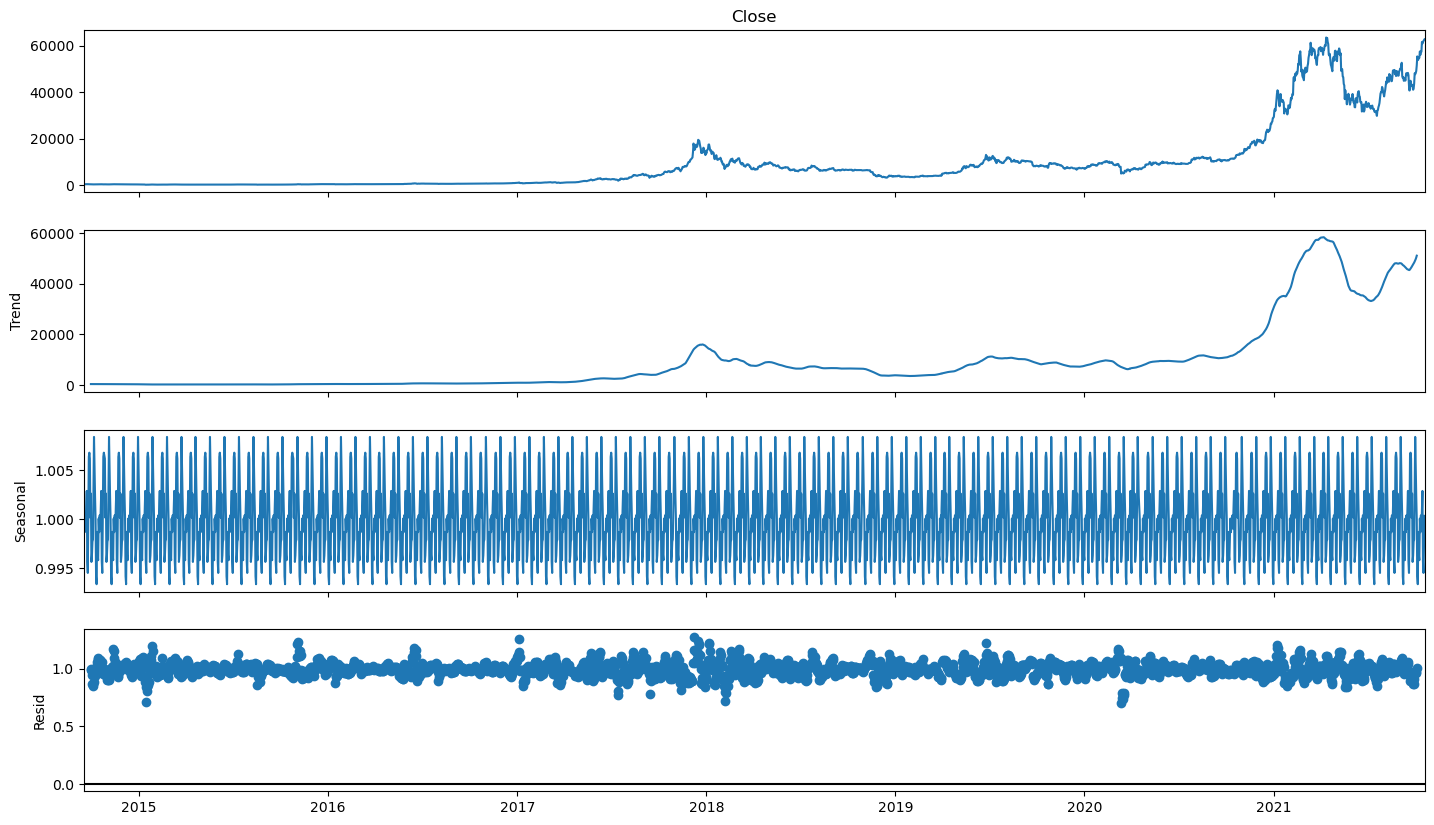

In [9]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a month
# The result below is just to have a first visualization of trend andseasonality. Here we take a monthly average but to forecast a bitcoin 
# price, it is more difficult than that to choose the right number of days to average on
result = seasonal_decompose(df_close, model='multiplicative', period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

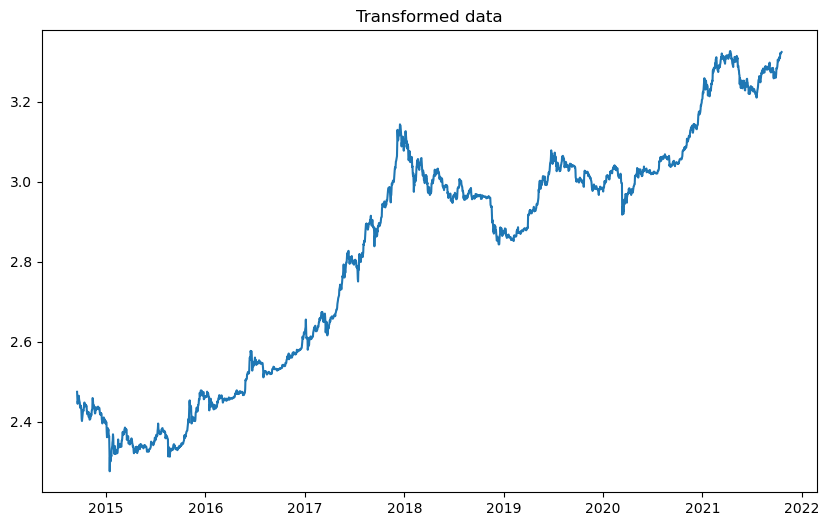

In [10]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data');

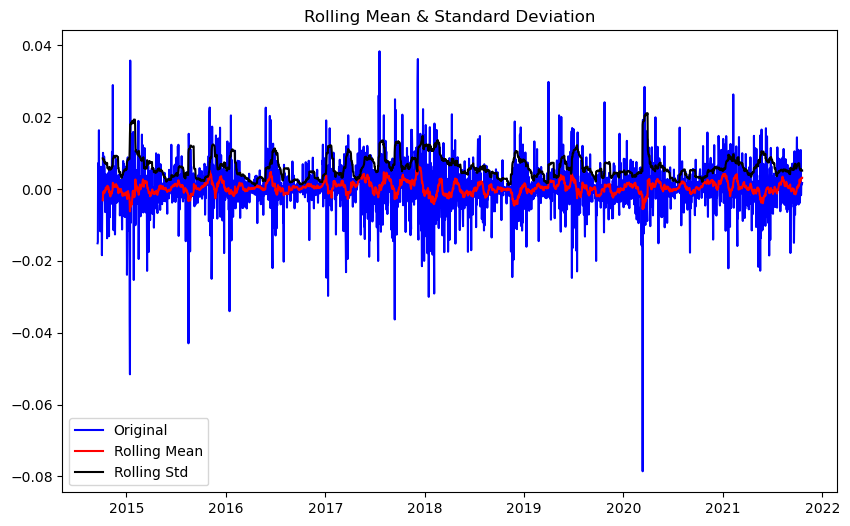

Results of Dickey-Fuller Test:
Test Statistic                -1.548004e+01
p-value                        2.563303e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.575000e+03
Critical Value (1%)           -3.432892e+00
Critical Value (5%)           -2.862663e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [11]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

# LSTM

In [12]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [13]:
# choose the number of days on which to base our predictions 
nb_days = 90

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [14]:
#Split the data set between the training set and the test set
train_days = int(len(y) * 0.8)

test_days = len(y) - train_days 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

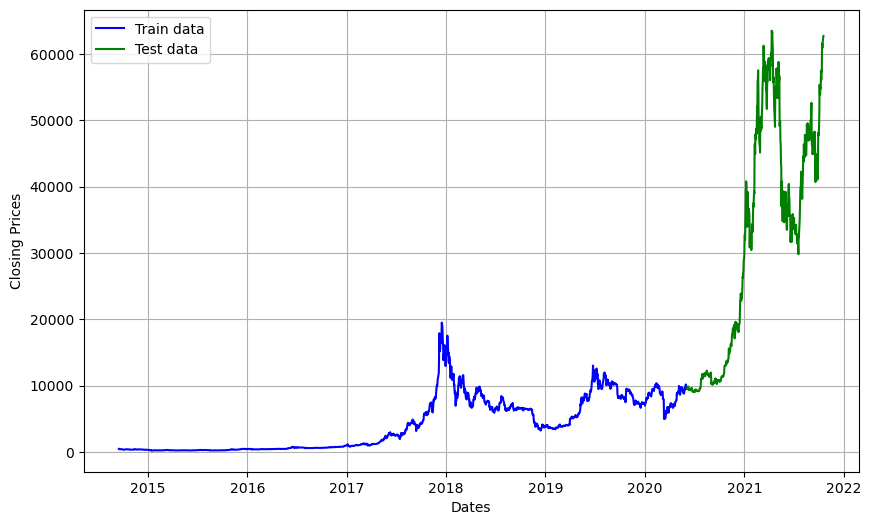

In [15]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend();

In [16]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=100,input_shape=(nb_days, n_features),return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=100,return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=100,return_sequences=True)) 
    model.add(Dropout(0.2))

    model.add(LSTM(units=90, activation = 'relu', return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(LSTM(units = 90, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    return model

In [17]:
model = vanilla_LSTM()
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 90, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 90, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 90, 90)            

In [18]:
# patience for the early stopping (number of epochs)
patience = 25

# Adding early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

model.fit(X_train, y_train, epochs=100, batch_size = 32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100

50/50 [==============================] - 33s 358ms/step - loss: 5.5738e-05 - mean_absolute_error: 0.0050 - val_loss: 5.8140e-05 - val_mean_absolute_error: 0.0048
Epoch 2/100
50/50 [==============================] - 15s 309ms/step - loss: 5.1187e-05 - mean_absolute_error: 0.0046 - val_loss: 5.6557e-05 - val_mean_absolute_error: 0.0046
Epoch 3/100
50/50 [==============================] - 14s 285ms/step - loss: 5.1288e-05 - mean_absolute_error: 0.0047 - val_loss: 5.6648e-05 - val_mean_absolute_error: 0.0047
Epoch 4/100
50/50 [==============================] - 15s 300ms/step - loss: 5.0977e-05 - mean_absolute_error: 0.0046 - val_loss: 5.6477e-05 - val_mean_absolute_error: 0.0046
Epoch 5/100
50/50 [==============================] - 14s 289ms/step - loss: 5.1504e-05 - mean_absolute_error: 0.0047 - val_loss: 5.7700e-05 - val_mean_absolute_error: 0.0047
Epoch 6/100
50/50 [==============================] - 14s 282ms/step - loss: 5.1227e-05 - mean_absolute_error: 0.0046 - val_loss: 

16/16 [==============================] - 1s 88ms/step


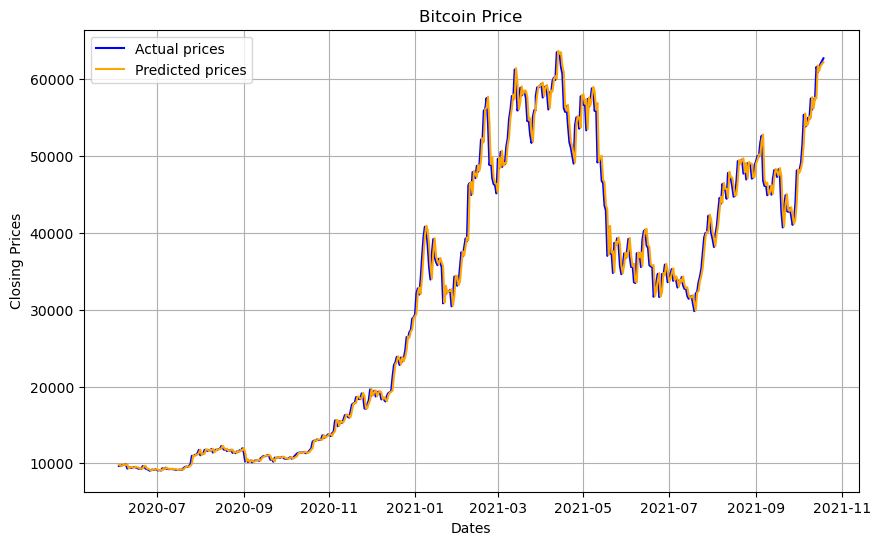

In [27]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data_LSTM = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data_LSTM['Close'] = pred_data_LSTM['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data_LSTM = pred_data_LSTM.apply(np.square)
pred_data_LSTM = pred_data_LSTM.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data_LSTM, 'orange',label='Predicted prices')
plt.title('Bitcoin Price')

plt.legend();

In [28]:
print('LSTM MAE:',mean_absolute_error(test_original, pred_data_LSTM))
print('RMSE:')
print('LSTM RMSE:',math.sqrt(mean_squared_error(test_original, pred_data_LSTM)))

LSTM MAE: 951.5479949158561
RMSE:
LSTM RMSE: 1505.5778680965402


# Let's Make Money

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [30]:
# Building Prediction Matrix from the outputs of LSTM
pred_data = pred_data_LSTM
pred_data['Actual'] = test_original
pred_data = pred_data.rename(columns = {'Close': 'Predictions'})
pred_data['Sell'] = 0
pred_data['Buy'] = 0

for i in range(len(pred_data)-1):
    if (pred_data['Predictions'][i+1] - pred_data['Predictions'][i])*100/pred_data['Predictions'][i] > 5:
        pred_data['Buy'][i] = 1
    if (pred_data['Predictions'][i+1] - pred_data['Predictions'][i])*100/pred_data['Predictions'][i] < (-5):
        pred_data['Sell'][i] = 1

In [31]:
# Defining function which will buy and sell it 
def buy_sell_trades(predictions):
   
    money = 100000
    stock = 0

    print('Money in buy and hold strategy ',(money/predictions['Actual'][0])*predictions['Actual'][len(predictions)-1])
    for i in range(len(predictions)):
        if (predictions['Buy'][i] == 1):
            if (money != 0):
                stock = money/predictions['Actual'][i]
                money = 0
            if (money == 0):
                pass
        if (predictions['Sell'][i] == 1):
            if (stock != 0):
                money = stock * predictions['Actual'][i]
                stock = 0
            if (stock == 0):
                pass

    
    print('Money after trading:', money+stock*predictions['Actual'][len(predictions)-1])

In [32]:
buy_sell_trades(pred_data)

Money in buy and hold strategy  648790.2306365911
Money after trading: 683408.1144581621


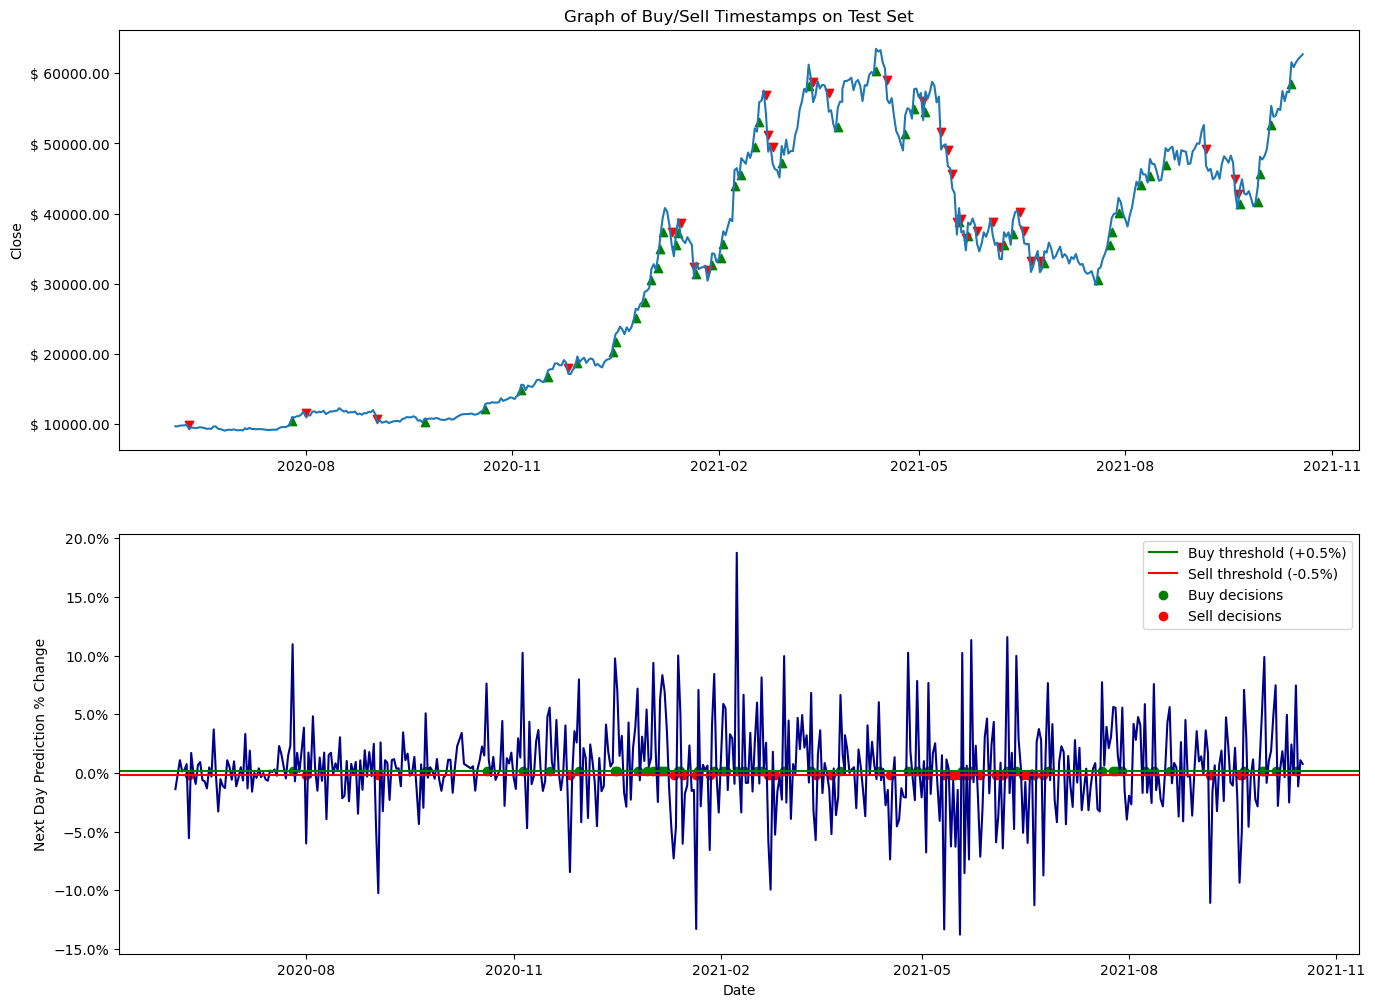

In [33]:
pred_data['Dates'] = pred_data.index
    
DATE_COLS = ['Dates']

ts_df = pred_data[['Dates','Predictions', 'Actual']]   
buy_sell_df = pred_data[['Dates','Buy','Sell']] 
buy_dates = buy_sell_df[buy_sell_df.Buy == 1].Dates
sell_dates = buy_sell_df[buy_sell_df.Sell == 1].Dates

buy_decisions = ts_df[ts_df.Dates.isin(buy_dates)]
sell_decisions = ts_df[ts_df.Dates.isin(sell_dates)]

ts_df['next_day_pct_change_pred'] = ts_df.Predictions.pct_change(periods=1).shift(-1) * 100
pct_change_df = ts_df.dropna()

months = mdates.MonthLocator(interval=3)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


## FIRST SUBPLOT

ax1.plot(ts_df.Dates, ts_df.Actual)
ax1.scatter(buy_decisions.Dates, buy_decisions.Actual * 0.95, color = 'green', marker = '^')
ax1.scatter(sell_decisions.Dates, sell_decisions.Actual * 1.05, color = 'red', marker = 'v')

# format title, x/y axis
dollar_formatter = ticker.FormatStrFormatter('$ %1.2f')
ax1.yaxis.set_major_formatter(dollar_formatter)
ax1.xaxis.set_major_locator(months)
ax1.set_ylabel('Close')
ax1.set_title('Graph of Buy/Sell Timestamps on Test Set')


## SECOND SUBPLOT

ax2.plot(pct_change_df.Dates, pct_change_df.next_day_pct_change_pred, color='darkblue')
ax2.axhline(y=0.15, color='green', label='Buy threshold (+0.5%)')
ax2.axhline(y=-0.15, color='red', label='Sell threshold (-0.5%)')
ax2.scatter(buy_decisions.Dates, [0.15] * len(buy_decisions), color='green', label='Buy decisions')
ax2.scatter(sell_decisions.Dates, [-0.15] * len(sell_decisions), color='red', label='Sell decisions')

# format title, x/y axis
ax2.legend()
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.xaxis.set_major_locator(months)
ax2.set_ylabel('Next Day Prediction % Change')
ax2.set_xlabel('Date')


plt.show()
